In [1]:
import numpy as np
from cosmoTransitions.tunneling1D import SingleFieldInstanton
from cosmoTransitions import generic_potential_Gegenbauer
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc
from scipy.special import hyp2f1



%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size

label_size=20
thick_size=20


####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
gtab = np.loadtxt( 'standardmodel2018.txt' )[::20]
g_star=interpolate.interp1d(gtab[::,0], gtab[::,1], kind='cubic')
g_sstar=interpolate.interp1d(gtab[::,0], gtab[::,3], kind='cubic')


def Hubble_radiation(T):
    """Hubble rate (squared) coming from radiation dof"""
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared

def Gamma_Hubble4(S,T):
    """Nucleation probability per Hubble volume, including matter contribution. 
    Integrand in formula (2.2) 1809.08242 """
    Gamma1=T**4*np.exp(-S/T)*np.sqrt((S/2/np.pi/T))**(3)
    return Gamma1


####MY FUNCTIONS START HERE      

def GBpotential(Ngb,n,z):
    lam=(Ngb-1)/2
    return hyp2f1(-n/2,n/2+lam,lam+1/2,z**2)

def DGBpotential(Ngb,n,z):
    fun=lambda z :GBpotential(Ngb,n,z)
    output=misc.derivative(fun, x0=z, dx=1e-2, n=1)
    return output

def D2GBpotential(Ngb,n,z):
    fun=lambda z :DGBpotential(Ngb,n,z)
    output=misc.derivative(fun, x0=z, dx=1e-2, n=1)
    return output

def findZeros(Ngb,n):
    fun=lambda z :GBpotential(Ngb,n,z)
    Dfun=lambda z :DGBpotential(Ngb,n,z) 
    D2fun=lambda z :D2GBpotential(Ngb,n,z) 
    sols=[]
    for i in np.linspace(0,1,30):
        #sol=optimize.fmin(Dfun, x0=i,disp=False,ftol=1e-25)
        sol=optimize.root(Dfun, x0=i)
        #sol=optimize.root(Dfun, [i], jac=Dfun, method='hybr')
        if sol.x<0 or D2fun(sol.x)<0 or abs(Dfun(sol.x))>1:
            continue
        sols.append(np.round(sol.x,4))
        
    return np.unique(sols)




In [2]:
# Ngb,n=4,15
# 
# z_range=np.linspace(0.00001,1,200)
# zeros_list=findZeros(Ngb,n)
# plt.plot(z_range,GBpotential(Ngb,n,z_range))
# plt.scatter(zeros_list,GBpotential(Ngb,n,zeros_list))
# 
# plt.xlabel("$\Pi/f$",size=label_size)
# plt.ylabel("$G$",size=label_size)
# plt.xticks(fontsize=thick_size)
# plt.yticks(fontsize=thick_size)
# plt.grid(True)
# 
# plt.show()

In [3]:
class model1(generic_potential_Gegenbauer.generic_potential):

    def init(self, Ngb=4, n=20):
        self.Ndim = 1
        self.Ngb=Ngb
        self.n=n
        self.vacua_list = findZeros(Ngb,n)
        self.f=v/self.vacua_list[0]
        self.renormScaleSq = self.f**2
        self.renormScaleSq = v**2
        
        ##Determine normalization constant
        fun=lambda h :GBpotential(Ngb,n,h/self.f)
        DG=misc.derivative(fun, x0=v, dx=1e-2, n=1,order=5)
        D2G=misc.derivative(fun, x0=v, dx=1e-2, n=2,order=5)
        self.const=mh**2/((-v*DG+(self.f**2-v**2)*D2G)/self.f**2)
        #print(self.const/self.f**4)
    

 
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -1.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h = X[...]
        z=h/self.f
        pot =self.const*GBpotential(self.Ngb,self.n,z)
        
        return pot
    
    def Higgs_trilinear(self):
        """This method compute the Higgs trilinear with respect to the SM value"""
        chhhSM = 3*mh**2/v
        DG3=misc.derivative(self.V0, x0=v, dx=1e-1, n=3,order=7)
        self.Higgs_trilinear=DG3/chhhSM
        return DG3/chhhSM

    
    def plot1(self):
        z_range=np.linspace(0,self.f,200)

        plt.plot(z_range,self.V0(z_range),label="Tree-level")
        plt.scatter(self.vacua_list*self.f,self.V0(self.f*self.vacua_list))

        plt.xlabel("$\Pi/f$",size=label_size)
        plt.ylabel("$G$",size=label_size)
        plt.legend()
        plt.legend(prop={'size': label_size})
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        #mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
        #plt.title(mytitle,size=label_size)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
    def plot2(self,T):
        z_range=np.linspace(1e-3,self.f,200)

        plt.plot(z_range,self.Vtot(z_range,T),"g--",label="1-loop potential")
        #plt.scatter(self.vacua_list*self.f,self.Vtot(self.f*self.vacua_list,0))
        
        plt.legend()
        plt.legend(prop={'size': label_size})
        plt.xlabel("$\Pi/f$",size=label_size)
        plt.ylabel("$G$",size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        mytitle="Effective potential at T= "+str(np.round(T,1))+" GeV"
        plt.title(mytitle,size=label_size)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
    
    def boson_massSq(self, X, T):
        X = np.asanyarray(X)
        h = X[...,]
        
        ##Determine normalization constant
        fun=lambda x :self.V0(x)
        DG=misc.derivative(fun, x0=h,  n=1)
        D2G=misc.derivative(fun, x0=h, n=2)

        Mh2=(-h*DG+(self.f**2-h**2)*D2G)/self.f**2
        MG2=(self.f**2-h**2)*DG/self.f**2/(h+1e-100)

        M = np.array([Mh2,MG2])
        M = np.rollaxis(M, 0, len(M.shape))


        dof = np.array([1,self.Ngb-1])

        c = np.array([.5,.5])

        return M, dof, c
    
    def fermion_massSq(self, X):
        X = np.asanyarray(X)
        h = X[...,]

        mt=1**2*h**2/2
        M = np.array([mt])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.
        dof = 0*np.array([12])
        return M, dof
    
    def approxZeroTMin(self):
        return list(self.vacua_list*self.f)

    
    def findMinima(self,T):
        """Find minima of the potential at temperature T. 
        It only tracks the minima closest to the origin"""
        fun=lambda z :self.Vtot(z,T)
        Dfun=lambda z :misc.derivative(fun, x0=z, dx=1e-1, n=1)
        D2fun=lambda z :misc.derivative(fun, x0=z, dx=1e-1, n=2)
        sols=[]
        h_range=np.linspace(0,v,100)
        for i in range(0,len(h_range)):
            sol=optimize.fmin(self.Vtot,h_range[i],args=(T,),disp=False)
            #sol=optimize.root(Dfun, [i], jac=Dfun, method='hybr')
            #print(Dfun(sol.x))
            if sol<=0 or sol>v or D2fun(sol)<=0 or abs(Dfun(sol))>100:
                print(sol,Dfun(sol),D2fun(sol))
                continue
            sols.append(np.round(sol,1))
                
        return sorted(np.unique(sols))
    
    def findMinima_old(self,T):
        """Find minima of the potential at temperature T. 
        It only tracks the minima closest to the origin"""
        fun=lambda z :self.Vtot(z,T)
        Dfun=lambda z :misc.derivative(fun, x0=z, dx=1e-1, n=1)
        D2fun=lambda z :misc.derivative(fun, x0=z, dx=1e-1, n=2)
        sols=[]
        h_range=np.linspace(0,v,200)
        i=0
        while True:
            if i>=len(h_range) or h_range[i]>v+10:
                break
            sol=optimize.fmin(self.Vtot,h_range[i],args=(T,),disp=False)
            sol=float(np.round(sol,1))
            #print(i,sol,sols)
            if sol<=0 or sol>v or D2fun(sol)<=0 or abs(Dfun(sol))>500:
                #print(sol,Dfun(sol),D2fun(sol))
                i+=2
                continue
            elif sol in sols:
                i+=15
                continue
            else:
                i+=1
                sols.append(sol)
                
        return sorted(np.unique(sols))
    
    
    def nucleation_(self,T):
        """compute the instanton and return nucleation rate Gamma, Euclidean action S_3, 
        Hubble rates(squared) H_1 (radiation) and H_2 (vacuum)"""
        Temp=T
        min_list=self.findMinima(Temp)
        if len(min_list)<=1:
            return
        
        phi_false=min_list[0]
        phi_true=min_list[-1]
        pot_fun=lambda h : self.Vtot(h,Temp)
        
        if phi_false>phi_true or (phi_true-phi_false)<10 or pot_fun(phi_true)>pot_fun(phi_false):
            return 
        
        VT_false=lambda T : self.Vtot(phi_false,T)
        DVT_false=misc.derivative(VT_false, x0=Temp, dx=1e-1, n=1)
        VT_true=lambda T : self.Vtot(phi_true,T)
        DVT_true=misc.derivative(VT_true, x0=Temp, dx=1e-1, n=1)
        rho_r= g_star(Temp)*np.pi**2/30*Temp**4
        alpha_strength=(self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp)-Temp/4*(DVT_false-DVT_true))/rho_r
        vwall=np.sqrt((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/alpha_strength/rho_r)
        vJ=1/3**.5*(1+np.sqrt(3*alpha_strength**2+2*alpha_strength))/(1+alpha_strength)
        if vwall>=vJ:
            vwall=1

        instanton=SingleFieldInstanton(phi_true, phi_false, pot_fun)
        phi_profile=instanton.findProfile()
        S_3=instanton.findAction(phi_profile)
        Hubble1=Hubble_radiation(Temp)
        Hubble2=((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/3/Mplanck**2)
        Hubble=Hubble1+Hubble2
        Gamma_rate=Gamma_Hubble4(S_3,Temp)
        nuc_output={"phi_false":phi_false,"phi_true":phi_true,"Tn":Temp,"Gamma":Gamma_rate,"S_3":S_3,
                    "Hubble1":Hubble1,"Hubble2":Hubble2,
                    "alpha":alpha_strength,"vw":vwall,"vJ":vJ}
        return nuc_output 


        
        
    


True vacuum are h= [ 246.2         534.97359764  770.78979334  939.11126107 1024.88148461]
Confinement scale f= 1038.3804301982286


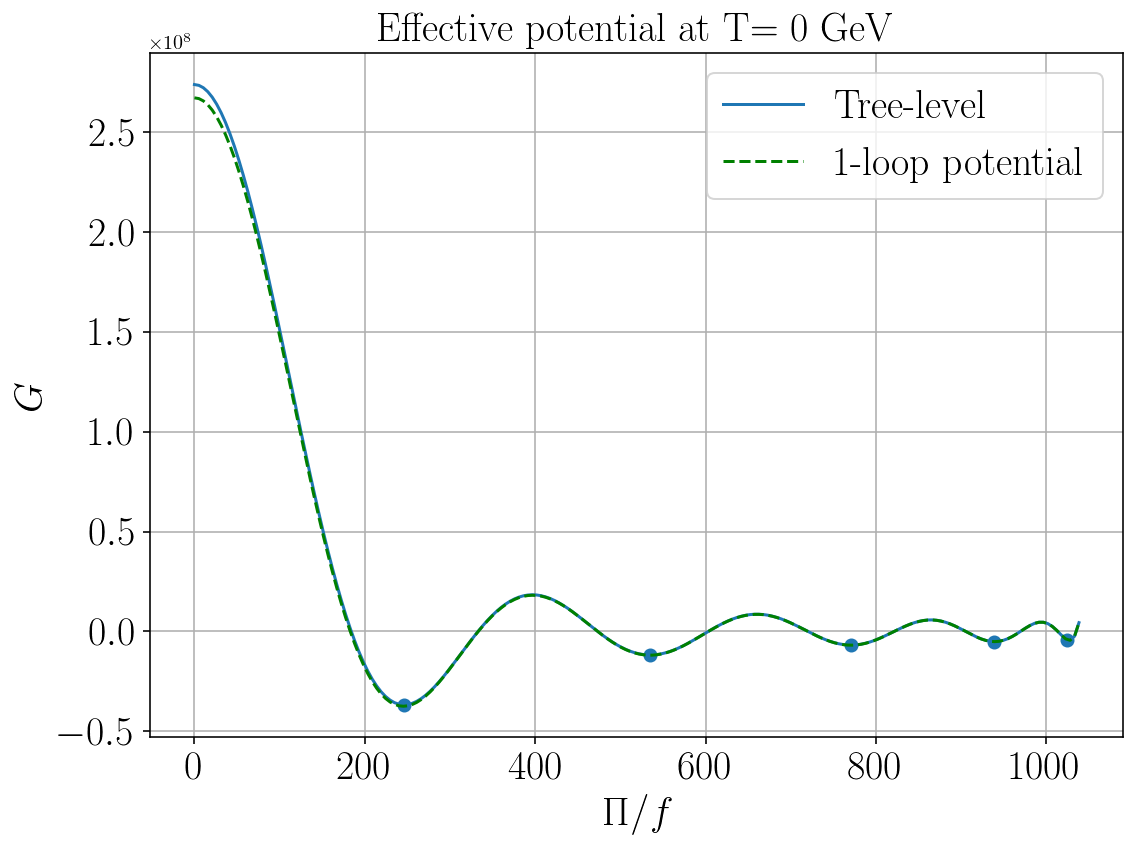

In [4]:
m=model1(Ngb=4, n=20)

print("True vacuum are h=",m.vacua_list*m.f)
print("Confinement scale f=",m.f)
m.plot1()
m.plot2(0)

#bosons=m.boson_massSq( 1e-5, 0)
#fermions=m.fermion_massSq(v)
#m.V1(bosons,fermions)
#m.Vtot(0,0)


CPU times: user 78.7 ms, sys: 7.18 ms, total: 85.9 ms
Wall time: 80.7 ms


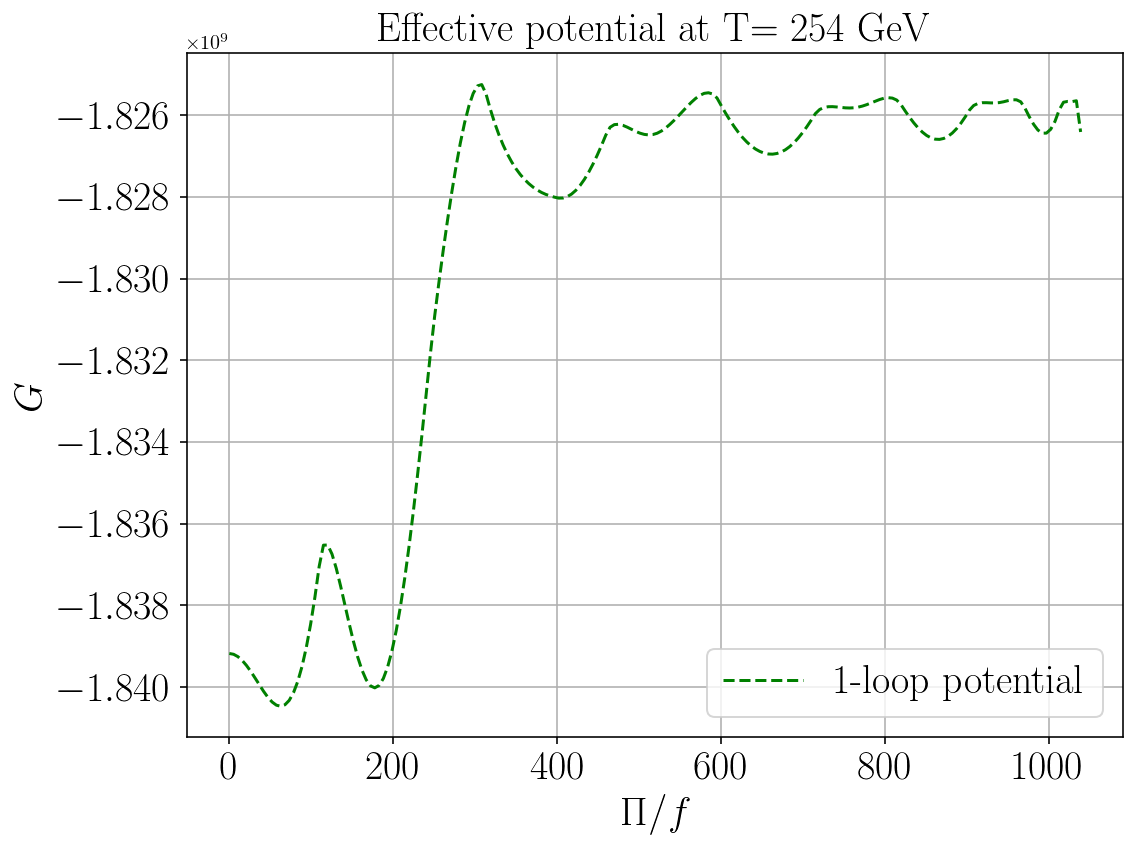

In [30]:
%%time

Temp=254
m.include_CW=True
m.plot2(Temp)


#min_list=m.findMinima(Temp)
#if len(min_list)>0:
#    plt.scatter(min_list,m.Vtot(min_list,Temp),c="b",marker="X")
#plt.xlim(-1e-1,210)

In [15]:
some_fun(Temp) 

array([185.46107306, 517.85252012, 762.2939771 , 993.95863807,
       993.96104276])

In [7]:
def some_fun(Temp):
    vac_list=[]
    for h0 in list(m.vacua_list*m.f):
        vac_list.append(float(m.findMinimum(h0,Temp)))
    return np.array(vac_list)


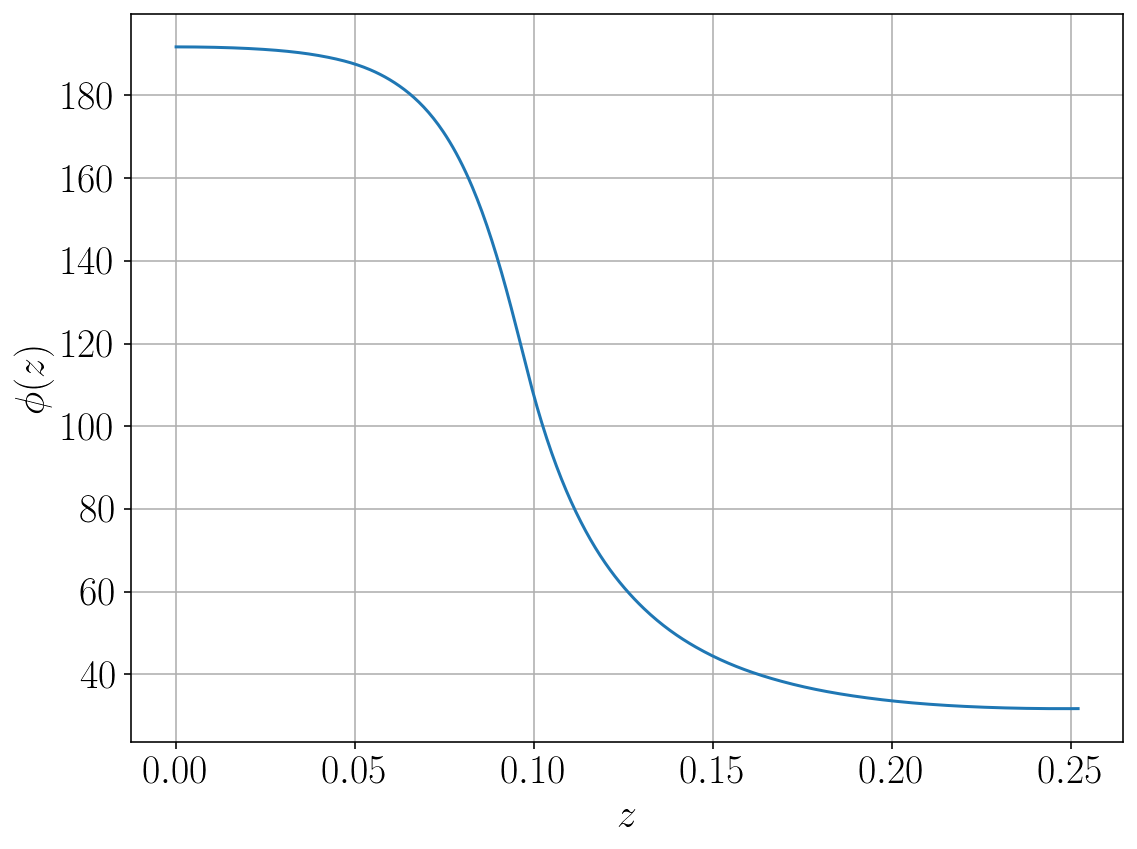

In [210]:
phi_false=min_list[0]
phi_true=min_list[-1]
r_range=np.linspace(phi_false,phi_true)
pot_fun=lambda h : m.Vtot(h,Temp)

instanton=SingleFieldInstanton(phi_true, phi_false, pot_fun)
phi_profile=instanton.findProfile()
S_3=instanton.findAction(phi_profile)
Hubble1=Hubble_radiation(Temp)
Hubble2=((m.Vtot(phi_false,Temp)-m.Vtot(phi_true,Temp))/3/Mplanck**2)
Hubble=Hubble1+Hubble2
Gamma_rate=Gamma_Hubble4(S_3,Temp)


plt.plot(phi_profile.R, phi_profile.Phi)
plt.xlabel("$z$",size=label_size)
plt.ylabel("$\phi(z)$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
#mytitle="Effective potential at T= "+str(T)+" GeV"
#plt.title(mytitle,size=label_size)
plt.tight_layout()

In [211]:
Hubble1,Hubble2



(7.265236928766289e-27, 3.606714666572572e-31)

In [212]:
Gamma_rate/Hubble**2,Gamma_rate,np.exp(-140)

(3.1601029008220354e+41, 1.6681838284577178e-11, 1.580420060273613e-61)

In [213]:
S_3/Temp,S_3

(49.947674996366345, 12287.12804910612)

In [214]:
m.nucleation_(Temp)

{'phi_false': 26.4,
 'phi_true': 192.7,
 'Tn': 246,
 'Gamma': 1.6681838284577178e-11,
 'S_3': 12287.12804910612,
 'Hubble1': 7.265236928766289e-27,
 'Hubble2': 3.606714666572572e-31,
 'alpha': 0.0011683975492529717,
 'vw': 0.20612738010635967,
 'vJ': 0.6045776762057129}

In [12]:
nucleation_list=[]
for temp in np.linspace(240,250):
    try:
        #Gamma_rate, S_3, Hubble1, Hubble2 = m.nucleation_(temp)
        #nuc_output={"Tn":temp,"Gamma":Gamma_rate,"S_3":S_3,"Hubble1":Hubble1,"Hubble2":Hubble2}
        nuc_output=m.nucleation_(temp)
        if len(nuc_output)!=0:
            nucleation_list.append(nuc_output)
    except:
        continue
    
df_nuc=pd.DataFrame(nucleation_list).dropna()



/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by 

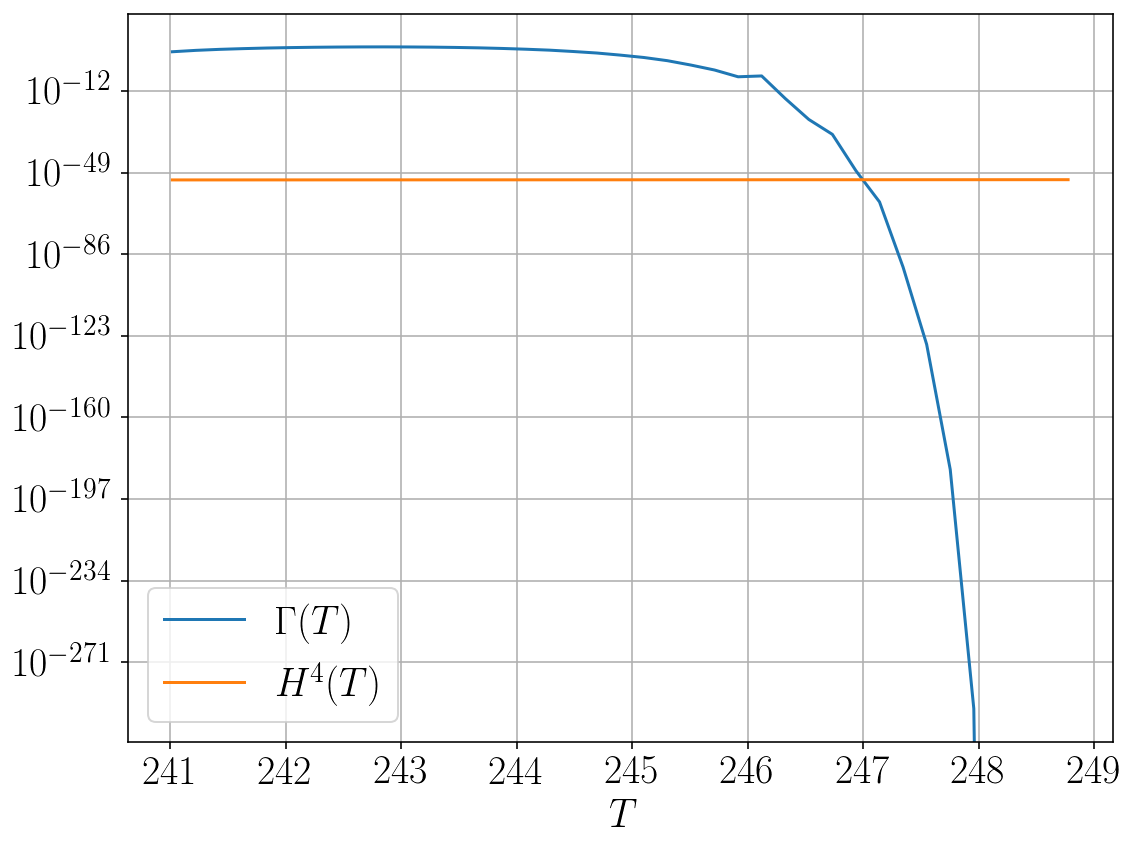

In [13]:
plt.plot(df_nuc["Tn"],df_nuc["Gamma"],label="$\Gamma(T)$")
plt.plot(df_nuc["Tn"],(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2,label="$H^4(T)$")
#plt.plot(df_nuc["Tn"],N_nuc(df_nuc["Tn"])+1)
plt.yscale("log")

plt.xlabel("$T$",size=label_size)
#plt.ylabel("$\Gamma/H^4$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend()
plt.legend(prop={'size': label_size})
#mytitle="Effective potential at T= "+str(T)+" GeV"
#plt.title(mytitle,size=label_size)
plt.tight_layout()

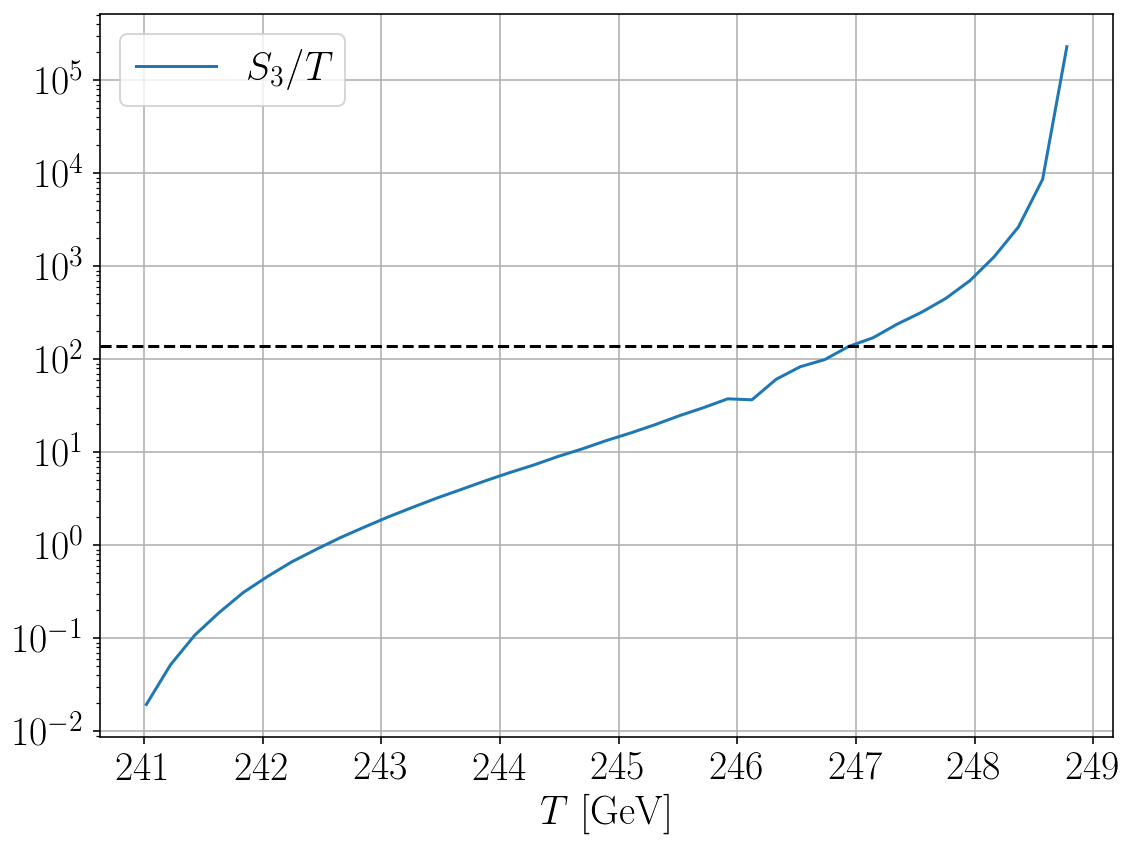

In [14]:

plt.plot(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"],label="$S_3/T$")

plt.yscale("log")
plt.xlabel("$T$ [GeV]",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend()
plt.legend(prop={'size': label_size})
plt.tight_layout()
plt.axhline(y=140,c="k",linestyle="--",label="140")

In [15]:
N_nuc=interpolate.interp1d(df_nuc["Tn"],(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2/df_nuc["Gamma"]-1)
Tnuc=optimize.root_scalar(N_nuc,bracket=(df_nuc["Tn"].min(),df_nuc["Tn"].max())).root

S_T_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"])
beta=Tnuc*misc.derivative(S_T_inter, x0=Tnuc, dx=1e-0, n=1)

alpha_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["alpha"])


In [16]:
LISA_sens = np.loadtxt( 'PLS_ESACallv1-2_04yr.txt' )[::20]


def v_J(alph):
    """Jouguet velocity"""
    return (1/3**.5 + (2*alph/3+alph**2)**.5)/(1+alph)
def kappa_swC(alph):
    return alph**.5/(0.135+(0.98+alph)**.5)
def kappa_swD(alph):
    return alph/(.73+0.083*alph**.5+alph)
def kappa_sw(alph,vw):
    return (v_J(alph)-1)**3*v_J(alph)**2.5*vw**(-2.5)*kappa_swC(alph)*kappa_swD(alph)/(((v_J(alph)-1)**3-(vw-1)**3)*v_J(alph)**2.5*kappa_swC(alph)+(vw-1)**3*kappa_swD(alph))
def Omega_GW(Tn,alph,bet,vw):
    factor=(8*np.pi)**(1/3)*vw/(3/4*kappa_sw(alph,vw)*alph/(1+alph))**.5/bet
    if factor>1:
        factor=1
    return 1.67e-5*(g_star(Tn)/100)*(g_sstar(Tn)/100)**(-4/3.)*5*(vw-cs)*(kappa_sw(alph,vw)*alph/(1+alph))**2*4/3/np.pi**2/bet*factor
def fp(Tn,alph,bet,vw):
    return 2.6323113e-6*(g_star(Tn)/100)**(1/6.)*(Tn/100)*bet
def f2overfp(vw):
    return 1/(vw-cs)
def normalization(f2overfp):
    return -2.23*f2overfp**(-4) + 5.03*f2overfp**(-3) - 2.61*f2overfp**(-2) + 2.42*f2overfp**(-1) + 0.21
def spectrum(f,fp,f2overfp):
    #print(f,fp,f2overfp)
    return normalization(f2overfp)*(f/fp)**3*(1+(f/fp)**3)**(-1)*(1+(f/f2overfp/fp)**4)**(-1)
def Omega_GWspectrum(Tn,alph,bet,vw):
    frange=np.logspace(-10,4,500)
    Omegaout=Omega_GW(Tn,alph,bet,vw)*spectrum(frange,fp(Tn,alph,bet,vw),f2overfp(vw))/spectrum(fp(Tn,alph,bet,vw),fp(Tn,alph,bet,vw),f2overfp(vw))
    return np.array([frange,Omegaout])

def SNR_GW(signal):
    """Computes SNR given signal (f,Omega)"""
    time=4
    f,Om=signal
    OmGW=interpolate.interp1d(f,Om, kind='cubic')
    Om=OmGW(LISA_sens[::,0])
    On=LISA_sens[::,3]
    integral=integrate.simps(Om**2/On**2,LISA_sens[::,0])
    SNR_val=(time*3.15*10**7*integral)**0.5

#    plt.plot(LISA_sens[::,0],OmGW(LISA_sens[::,0]))
#    plt.plot(LISA_sens[::,0],LISA_sens[::,3] )
#    plt.title("SNR="+str(SNR_val))
#    plt.xscale("log")
#    plt.yscale("log")
#    plt.xlabel("f[HZ]",size=label_size)
#    plt.ylabel("$\\Omega_{GW}$",size=label_size)
#    plt.xticks(fontsize=thick_size)
#    plt.yticks(fontsize=thick_size)
#    plt.show()
    return SNR_val




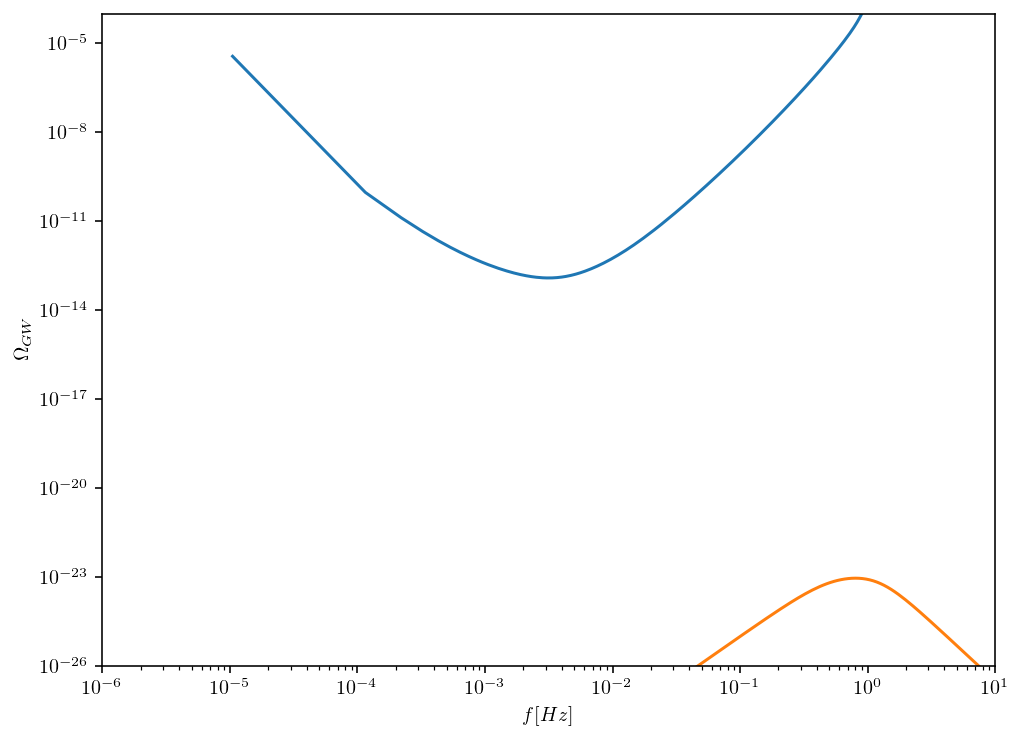

In [17]:
Temp,al,beta,vel=Tnuc,alpha_inter(Tnuc),beta,1

omega=Omega_GWspectrum(Temp,al,beta,vel)


plt.plot(LISA_sens[::,0],LISA_sens[::,3])
plt.plot(omega[0],omega[1])
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-26,1e-4)
plt.xlim(1e-6,10)
plt.xlabel("$f [Hz]$")
plt.ylabel("$\\Omega_{GW}$")
plt.show()